## Rescheduling 

In [9]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from models import *

# Utils
import src.utils.presenter as show
import src.utils.production_process.scheduling_preparation as schedule_prep

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 15 # 15 min

In [4]:
Job.clone_jobs(referenced_version="base", new_version="lateness_plus")
#JobOperation.clone_operations(referenced_version="base", new_version="lateness_plus")

✅ 622 Jobs von Version 'base' nach Version 'lateness_plus' kopiert.


## Laden des fertigen Datensatzes (3 Tage Ankunft)

In [5]:
# Jobs
df_jobs_times = Job.get_dataframe(version="lateness_plus")
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*3]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,77,1440,2760,open,lateness_plus
1,J25-0001,6,127,1440,2645,open,lateness_plus
2,J25-0002,0,194,1440,3800,open,lateness_plus
3,J25-0003,2,238,1440,4273,open,lateness_plus
4,J25-0004,3,280,1440,3284,open,lateness_plus
...,...,...,...,...,...,...,...
63,J25-0063,3,4177,4320,6566,open,lateness_plus
64,J25-0064,2,4240,4320,5907,open,lateness_plus
65,J25-0065,4,4281,4320,7469,open,lateness_plus
66,J25-0066,5,4299,4320,6540,open,lateness_plus


In [6]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [7]:
df_jssp = schedule_prep.get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
675,J25-0067,7,5,M06,88
676,J25-0067,7,6,M08,19
677,J25-0067,7,7,M09,48
678,J25-0067,7,8,M07,36


In [8]:
JobOperation.add_from_dataframe(df_jssp, version="lateness_plus", status="open")

✅ 680 JobOperation-Einträge (Version 'lateness_plus', Status 'open') wurden hinzugefügt oder aktualisiert.


### Params

In [9]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


## Tag 1 (init. Tag - kein Rescheduling)

In [10]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [11]:
# alle aktuelle "offenen" Jobs
df_job_times_curr = Job.get_dataframe(version="lateness_plus", arrival_time_max=day_start, status="open")
df_job_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,77,1440,2760,open,lateness_plus
1,J25-0001,6,127,1440,2645,open,lateness_plus
2,J25-0002,0,194,1440,3800,open,lateness_plus
3,J25-0003,2,238,1440,4273,open,lateness_plus
4,J25-0004,3,280,1440,3284,open,lateness_plus
5,J25-0005,1,487,1440,3743,open,lateness_plus
6,J25-0006,9,773,1440,3260,open,lateness_plus
7,J25-0007,5,905,1440,3124,open,lateness_plus
8,J25-0008,4,967,1440,3593,open,lateness_plus
9,J25-0009,7,982,1440,3575,open,lateness_plus


In [12]:
#  JSSP zu allen "offenen" Jobs
df_jssp_temp = schedule_prep.get_jssp_for_jobs(df_job_times_curr, df_routings)
df_jssp_temp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


In [13]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JobOperation.get_dataframe(version="lateness_plus", jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


### A) Scheduling

In [14]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(df_jssp_curr, df_job_times_curr, 
                                                                         schedule_start = day_start, w_t=5,
                                                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status         : OPTIMAL
Objective Value       : 22.00
Best Objective Bound  : 22.00
Laufzeit              : 0.22 Sekunden


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0000,8,0,M00,77,2760,1440,76,1516,-1244,0,1244
1,J25-0001,6,0,M01,127,2645,1440,46,1486,-1159,0,1159
2,J25-0007,5,0,M02,905,3124,1440,84,1524,-1600,0,1600
3,J25-0004,3,0,M01,280,3284,1486,81,1567,-1717,0,1717
4,J25-0011,1,0,M00,1008,2768,1516,43,1559,-1209,0,1209
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0002,0,9,M09,194,3800,3779,21,3800,0,0,0
156,J25-0014,4,9,M06,1196,3966,3913,53,3966,0,0,0
157,J25-0003,2,9,M04,238,4273,4240,33,4273,0,0,0
158,J25-0012,2,9,M04,1079,5140,5107,33,5140,0,0,0


In [15]:
json_schedule = df_schedule.to_dict(orient='records')

Schedule.add_schedule(
    data=json_schedule,
    date=day_numb,
    version="lateness_plus"
)

✅ Schedule hinzugefügt (Version=lateness_plus, Date=1)


### B) Simulation

In [16]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0000 started on M00
[Day 1 00:00:00] Job J25-0001 started on M01
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:35:32] Job J25-0001 finished on M01 (after 35 minutes 33 seconds)
[Day 1 00:46:00] Job J25-0004 started on M01
[Day 1 01:16:24] Job J25-0007 finished on M02 (after 76 minutes 25 seconds)
[Day 1 01:24:00] Job J25-0015 started on M02
[Day 1 01:41:08] Job J25-0000 finished on M00 (after 101 minutes 08 seconds)
[Day 1 01:41:08] Job J25-0011 started on M00
[Day 1 02:05:36] Job J25-0004 finished on M01 (after 79 minutes 37 seconds)
[Day 1 02:07:00] Job J25-0000 started on M01
[Day 1 02:17:37] Job J25-0011 finished on M00 (after 36 minutes 29 seconds)
[Day 1 02:17:37] Job J25-0001 started on M00
[Day 1 02:50:12] Job J25-0015 finished on M02 (after 86 minutes 12 seconds)
[Day 1 02:50:12] Job J25-0011 started on M02
[Day 1 02:51:37] Job J25-0001 finished on M00 (after 34 minutes)
[Day 1 02:51:37] Job J25-0010 started on M00
[Day 1 02:51:37] Job J25-000

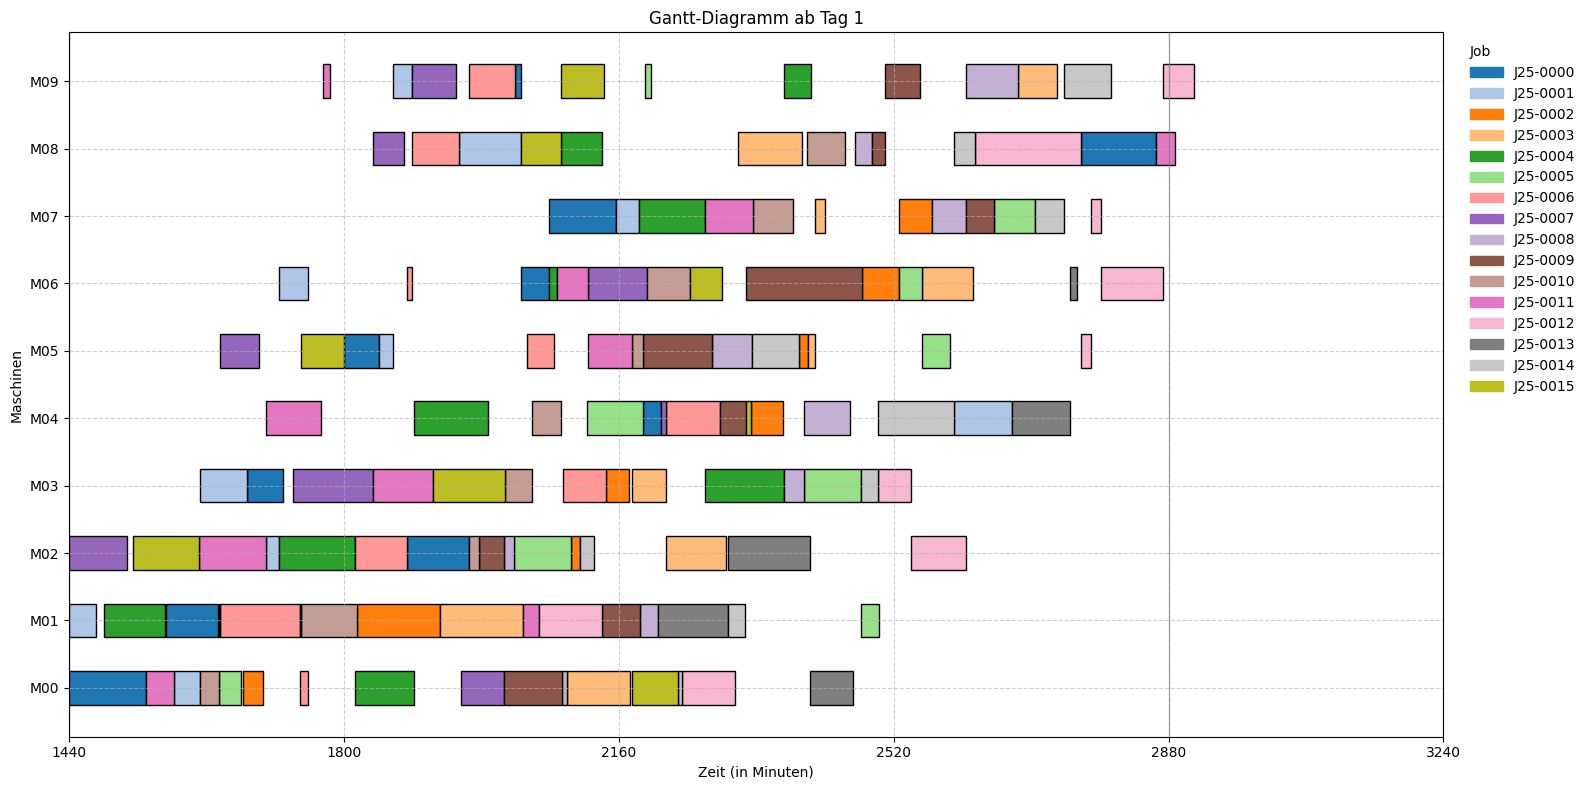

In [17]:
show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")

In [18]:
df_ops_finished = df_execution[df_execution.End < day_end]
JobOperation.add_from_dataframe(df_ops_finished, version="lateness_plus", status="finished")
df_ops_finished

✅ 140 JobOperation-Einträge (Version 'lateness_plus', Status 'finished') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,77,1440.00,101.14,1541.14
1,J25-0000,8,1,M01,77,1567.00,68.39,1635.39
2,J25-0000,8,2,M03,77,1673.59,46.20,1719.79
3,J25-0000,8,3,M05,77,1800.46,45.27,1845.73
4,J25-0000,8,4,M02,77,1882.90,81.39,1964.29
...,...,...,...,...,...,...,...,...
137,J25-0015,5,4,M08,1405,2031.86,52.35,2084.21
138,J25-0015,5,5,M09,1405,2084.21,56.93,2141.14
139,J25-0015,5,6,M00,1405,2177.00,60.41,2237.41
140,J25-0015,5,7,M06,1405,2252.86,42.33,2295.19


In [19]:
JobOperation.update_closed_jobs_from_operations(version="lateness_plus")

✅ 2 Job(s) wurden auf 'closed' gesetzt (Version 'lateness_plus').


['J25-0000', 'J25-0001']

In [20]:
df_ops_in_progess = df_execution[df_execution.End >= day_end]
JobOperation.add_from_dataframe(df_ops_in_progess, version="lateness_plus", status="in progress")
df_ops_in_progess

✅ 2 JobOperation-Einträge (Version 'lateness_plus', Status 'in progress') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
109,J25-0011,1,9,M08,1008,2864.07,24.39,2888.46
118,J25-0012,2,8,M09,1079,2872.22,41.36,2913.58


## II) Tag 2

In [21]:
this_version = "lateness_plus"

In [22]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [23]:
# alle aktuelle "offenen" Jobs
df_jobs_times_curr = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")
df_jobs_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0002,0,194,1440,3800,open,lateness_plus
1,J25-0003,2,238,1440,4273,open,lateness_plus
2,J25-0004,3,280,1440,3284,open,lateness_plus
3,J25-0005,1,487,1440,3743,open,lateness_plus
4,J25-0006,9,773,1440,3260,open,lateness_plus
...,...,...,...,...,...,...,...
31,J25-0033,2,2602,2880,4504,open,lateness_plus
32,J25-0034,8,2656,2880,4859,open,lateness_plus
33,J25-0035,5,2667,2880,4485,open,lateness_plus
34,J25-0036,4,2675,2880,5388,open,lateness_plus


In [24]:
#  JSSP zu allen "offenen" Jobs (auch fertige Operationen)
df_jssp_temp = schedule_prep.get_jssp_for_jobs(df_jobs_times_curr, df_routings)


#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JobOperation.get_dataframe(version=this_version, jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0002,0,8,M08,44
1,J25-0002,0,9,M09,21
2,J25-0003,2,9,M04,33
3,J25-0004,3,9,M05,43
4,J25-0005,1,9,M08,30
...,...,...,...,...,...
233,J25-0037,7,5,M06,88
234,J25-0037,7,6,M08,19
235,J25-0037,7,7,M09,48
236,J25-0037,7,8,M07,36


In [25]:
# Relevante 
df_ops_in_progess = JobOperation.get_dataframe(version=this_version, status="in progress")
df_ops_in_progess

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0011,1,M08,9,2864.07,2888.46,24.39,lateness_plus,in progress
1,J25-0012,2,M09,8,2872.22,2913.58,41.36,lateness_plus,in progress


In [26]:
## Hole den vorherigen Schedule
df_schedule = Schedule.get_schedule_as_dataframe(date=day_numb-1, version=this_version)

# Hole die offenen Operationen für die enthaltenen Jobs
df_open_ops = JobOperation.get_dataframe(version=this_version, jobs=df_schedule["Job"].unique().tolist(), status="open")

# Mache ein Inner Join auf ["Job", "Operation"]
df_schedule_prev = df_schedule.merge(df_open_ops[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_schedule_prev

ℹ️ Achtung: 2 Schedules gefunden – letzter Eintrag (ID 4) wird verwendet.


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0002,0,8,M08,194,3800,2768,44,2812,-988,0,988
1,J25-0013,3,5,M08,1166,5546,2812,52,2864,-2682,0,2682
2,J25-0013,3,6,M07,1166,5546,2864,85,2949,-2597,0,2597
3,J25-0013,3,7,M03,1166,5546,2949,98,3047,-2499,0,2499
4,J25-0013,3,8,M09,1166,5546,3047,22,3069,-2477,0,2477
5,J25-0007,5,9,M07,905,3124,3099,25,3124,0,0,0
6,J25-0006,9,9,M07,773,3260,3215,45,3260,0,0,0
7,J25-0004,3,9,M05,280,3284,3241,43,3284,0,0,0
8,J25-0015,5,9,M07,1405,3313,3288,25,3313,0,0,0
9,J25-0010,0,9,M09,1003,3391,3370,21,3391,0,0,0


In [29]:
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0002,0,8,M08,44
1,J25-0002,0,9,M09,21
2,J25-0003,2,9,M04,33
3,J25-0004,3,9,M05,43
4,J25-0005,1,9,M08,30
...,...,...,...,...,...
233,J25-0037,7,5,M06,88
234,J25-0037,7,6,M08,19
235,J25-0037,7,7,M09,48
236,J25-0037,7,8,M07,36


In [33]:
# Entfernung der Jobs (wo nur noch Operation in progress)
df_jobs_times_curr = df_jobs_times_curr[df_jobs_times_curr["Job"].isin(df_jssp_curr["Job"].unique())].copy()
df_jobs_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0002,0,194,1440,3800,open,lateness_plus
1,J25-0003,2,238,1440,4273,open,lateness_plus
2,J25-0004,3,280,1440,3284,open,lateness_plus
3,J25-0005,1,487,1440,3743,open,lateness_plus
4,J25-0006,9,773,1440,3260,open,lateness_plus
...,...,...,...,...,...,...,...
31,J25-0033,2,2602,2880,4504,open,lateness_plus
32,J25-0034,8,2656,2880,4859,open,lateness_plus
33,J25-0035,5,2667,2880,4485,open,lateness_plus
34,J25-0036,4,2675,2880,5388,open,lateness_plus


### Rescheduling

#### Old Version

$$
min   Z = r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| \text{Start}_{j,o} - \text{Start}_{j,o}^{\text{original}} \right|
$$



Solver-Status         : OPTIMAL
Objective Value       : 43440.00
Best Objective Bound  : 43440.00
Laufzeit              : 4.03 Sekunden
Deviation terms       : 18


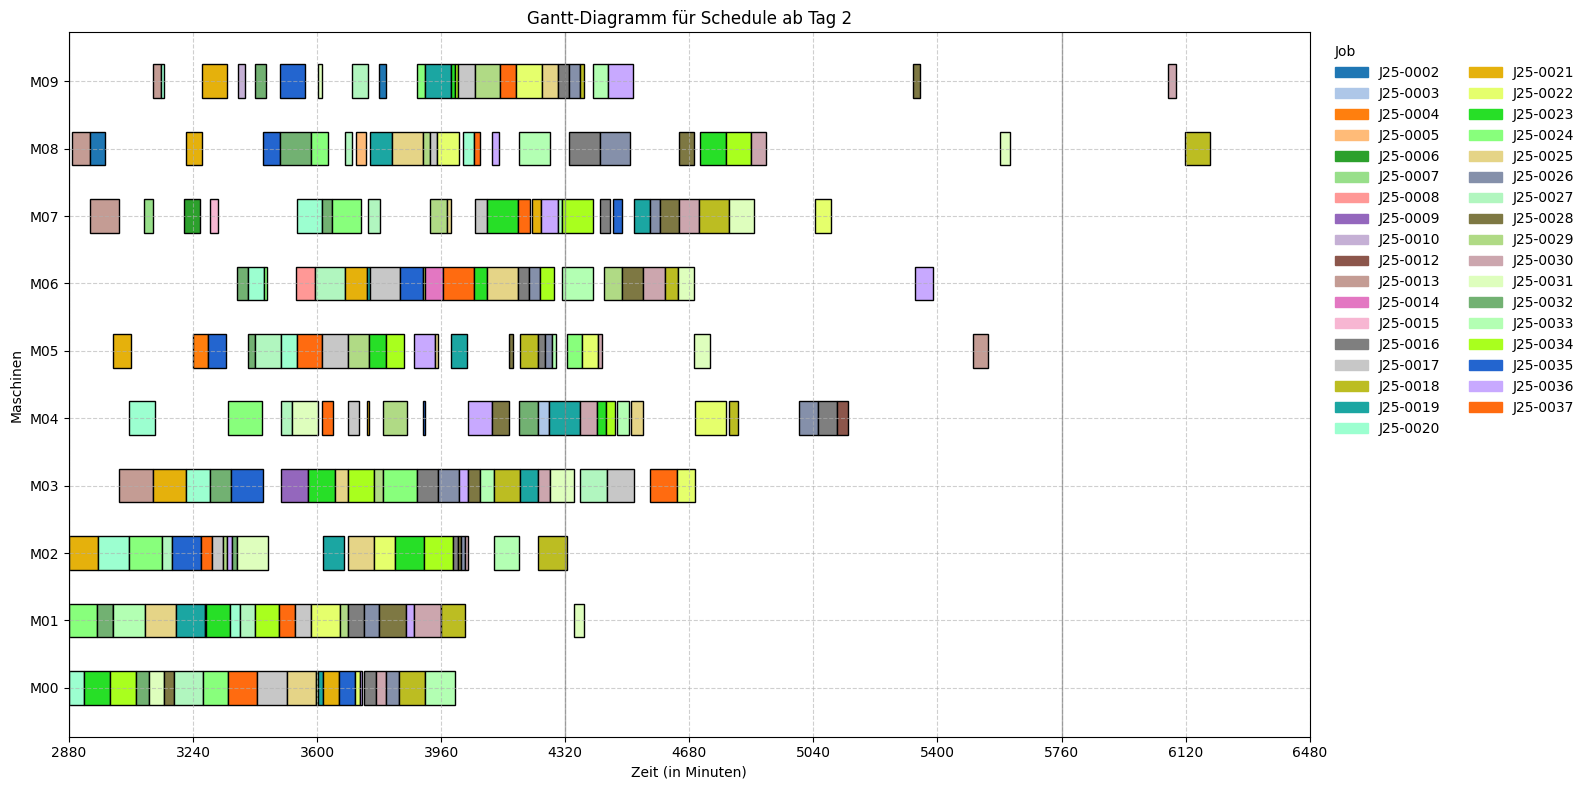

In [34]:
df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_jobs_times_curr, 
                                                                                   df_ops_in_progess, 
                                                                                   df_original_plan = df_schedule_prev,
                                                                                   w_t = 5,
                                                                                   r = 0.2, # 20% Lateness, 80% Deviation
                                                                                   reschedule_start = day_start, 
                                                                                   msg=False, timeLimit=max_time, gapRel= 0.001)

show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")

$$
Z = \alpha \cdot \left[
r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \max(0, C_j - D_j) + w_e \cdot \max(0, D_j - C_j) \right)
+ (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| S_{j,o} - S_{j,o}^{\text{orig}} \right|
\right]
- (1 - \alpha) \cdot \sum_{j \in \text{Jobs}} S_j^{\text{first}}
$$



Solver-Status         : FEASIBLE
Objective Value       : 2551570.00
Best Objective Bound  : 2533100.00
Laufzeit              : 904.88 Sekunden
Deviation terms       : 18


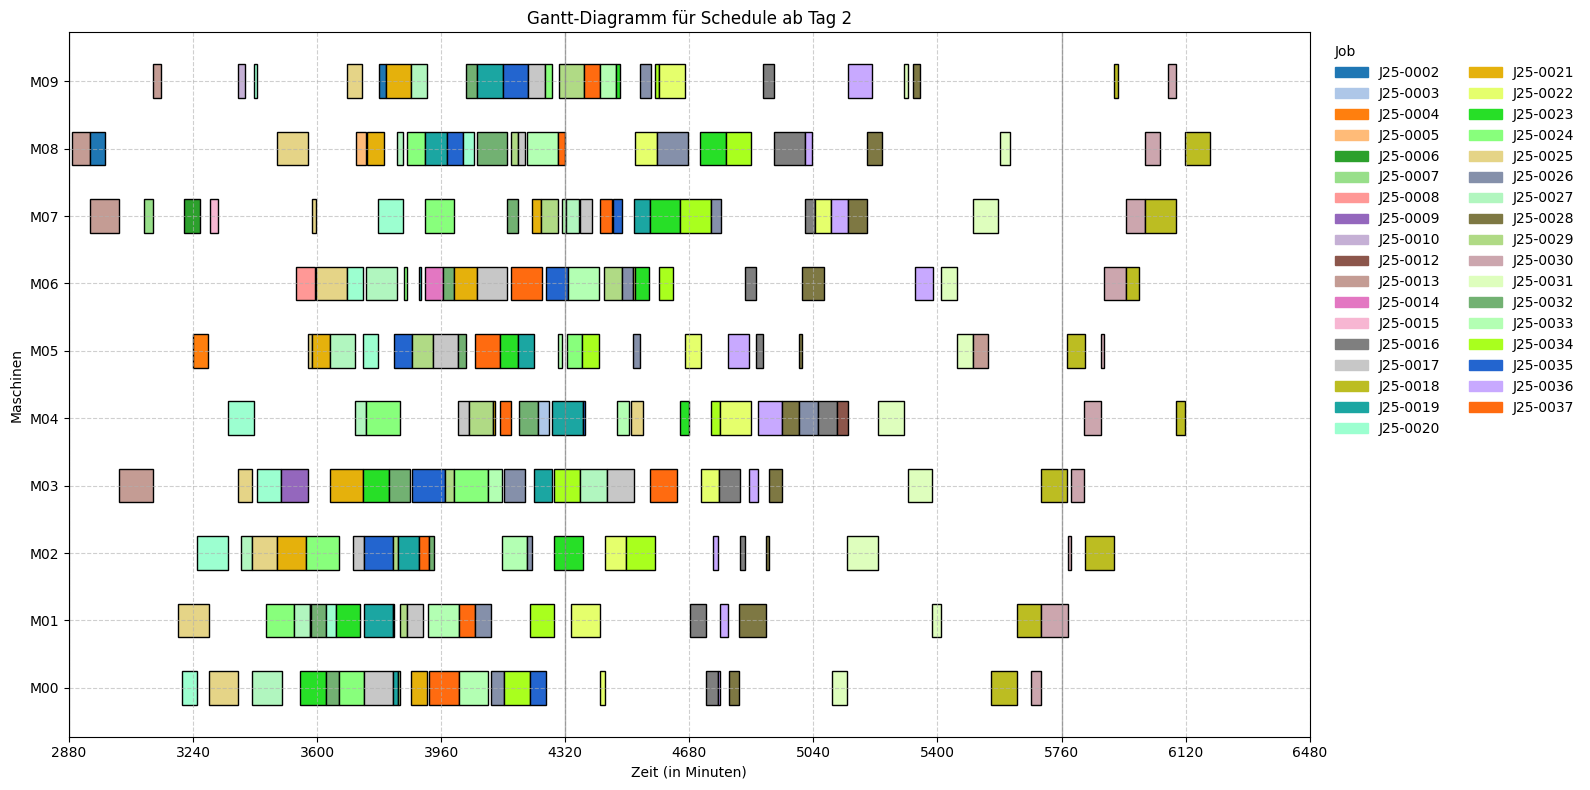

In [35]:
df_schedule = cp_late_reschedule.solve_jssp_advanced(df_jssp_curr, df_jobs_times_curr, df_ops_in_progess, 
                                                      df_original_plan = df_schedule_prev, w_t = 5,
                                                       r = 0.2, # 20% Lateness, 80% Deviation
                                                       reschedule_start = day_start, 
                                                       msg=False, timeLimit=max_time, gapRel= 0.001,
                                                      alpha =0.90)

show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")

# Simulation 

In [36]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 2 00:09:00] Job J25-0013 started on M08
[Day 2 01:14:55] Job J25-0013 finished on M08 (after 65 minutes 55 seconds)
[Day 2 01:14:55] Job J25-0002 started on M08
[Day 2 01:14:55] Job J25-0013 started on M07
[Day 2 01:59:55] Job J25-0002 finished on M08 (after 45 minutes 01 second)
[Day 2 02:23:46] Job J25-0013 finished on M07 (after 68 minutes 51 seconds)
[Day 2 02:26:00] Job J25-0013 started on M03
[Day 2 03:39:00] Job J25-0007 started on M07
[Day 2 04:00:00] Job J25-0007 finished on M07 (after 21 minutes 01 second)
[Day 2 04:27:49] Job J25-0013 finished on M03 (after 121 minutes 50 seconds)
[Day 2 04:27:49] Job J25-0013 started on M09
[Day 2 04:50:05] Job J25-0013 finished on M09 (after 22 minutes 16 seconds)
[Day 2 05:16:00] Job J25-0025 started on M01
[Day 2 05:28:00] Job J25-0020 started on M00
[Day 2 05:35:00] Job J25-0006 started on M07
[Day 2 06:00:29] Job J25-0020 finished on M00 (after 32 minutes 29 seconds)
[Day 2 06:01:00] Job J25-0004 started on M05
[Day 2 06:11:00] Jo

In [37]:
# previous "in progress" operations -> "finished"
df_ops_in_progess_prev = JobOperation.get_dataframe(version=this_version, status="in progress")
if df_ops_in_progess_prev is not None and not df_ops_in_progess_prev.empty:
    df_ops_in_progess_prev_finished = df_ops_in_progess_prev[df_ops_in_progess_prev.End <= day_end]
    JobOperation.add_from_dataframe(df_ops_in_progess_prev_finished, version=this_version, status="finished")


✅ 2 JobOperation-Einträge (Version 'lateness_plus', Status 'finished') wurden hinzugefügt oder aktualisiert.


In [38]:
# "finished" operations from current simulation
df_ops_finished = df_execution[df_execution.End < day_end]
JobOperation.add_from_dataframe(df_ops_finished, version=this_version, status="finished")
JobOperation.update_closed_jobs_from_operations(version=this_version)
df_ops_finished

✅ 112 JobOperation-Einträge (Version 'lateness_plus', Status 'finished') wurden hinzugefügt oder aktualisiert.
✅ 16 Job(s) wurden auf 'closed' gesetzt (Version 'lateness_plus').


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0002,0,8,M08,194,2954.92,45.01,2999.93
1,J25-0002,0,9,M09,194,3779.00,20.35,3799.35
2,J25-0003,2,9,M04,238,4263.36,40.97,4304.33
3,J25-0004,3,9,M05,280,3241.00,36.64,3277.64
4,J25-0005,1,9,M08,487,3713.00,43.56,3756.56
...,...,...,...,...,...,...,...,...
112,J25-0035,5,5,M09,2667,4160.09,65.86,4225.95
113,J25-0037,7,0,M02,2741,3913.70,27.29,3940.99
114,J25-0037,7,1,M00,2741,3940.99,65.26,4006.25
115,J25-0037,7,2,M01,2741,4099.45,50.87,4150.32


In [39]:
# "in progress" operations from current simulation
df_ops_in_progess = df_execution[df_execution.End >= day_end]
JobOperation.add_from_dataframe(df_ops_in_progess, version=this_version, status="in progress")
df_ops_in_progess   

✅ 6 JobOperation-Einträge (Version 'lateness_plus', Status 'in progress') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
31,J25-0019,9,7,M03,1883,4294.24,73.68,4367.92
64,J25-0024,3,8,M09,2062,4309.93,25.43,4335.36
75,J25-0026,6,1,M00,2144,4298.89,34.88,4333.77
91,J25-0029,4,7,M07,2251,4284.22,53.50,4337.72
106,J25-0034,8,1,M01,2656,4298.89,97.14,4396.03
117,J25-0037,7,4,M04,2741,4304.33,31.90,4336.23


In [40]:
# consistency check
df_ops_in_progess = JobOperation.get_dataframe(version="lateness_plus", status="in progress")
df_ops_in_progess

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0019,9,M03,7,4294.24,4367.92,73.68,lateness_plus,in progress
1,J25-0024,3,M09,8,4309.93,4335.36,25.43,lateness_plus,in progress
2,J25-0026,6,M00,1,4298.89,4333.77,34.88,lateness_plus,in progress
3,J25-0029,4,M07,7,4284.22,4337.72,53.50,lateness_plus,in progress
4,J25-0034,8,M01,1,4298.89,4396.03,97.14,lateness_plus,in progress
5,J25-0037,7,M04,4,4304.33,4336.23,31.90,lateness_plus,in progress
